In [1]:
#import all neccessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#define function to run query on db
#uses 'width' to open and close the connection with db
#function also returns a pandas dataframe with the query results
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
#define function to run queries that don't return a table
#uses 'isolation_level' to SQLite to autocommit any changes
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
#define function to run a query that returns all tables and views in the db
#uses the run_query function defined previously
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    print(run_query(q))

In [5]:
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


## Business Case
### You have been assigned to select 3 albums from a list of 4 to be added to the music store. In order to know which albums are the top 3 you will need to find which genres sell the most tracks in the USA. 
* Create a query to find out which genres sell the most tracks in the USA.
* Create a visualization of that data using pandas.

In [6]:
genre_usa_query = """ SELECT 
        A.name Genre, 
        COUNT(C.invoice_id) Tracks_Sold 
        FROM genre A
        JOIN track B
        ON A.genre_id = B.genre_id
        JOIN invoice_line C
        ON C.track_id = B.track_id
        JOIN invoice D
        ON C.invoice_id = D.invoice_id
        WHERE D.billing_country = 'USA'
        GROUP BY 1
        ORDER BY 1;"""

run_query(genre_usa_query)

,Genre,Tracks_Sold
0,Alternative,35
1,Alternative & Punk,130
2,Blues,36
3,Classical,4
4,Easy Listening,13
5,Electronica/Dance,5
6,Heavy Metal,3
7,Hip Hop/Rap,20
8,Jazz,14
9,Latin,22


In [7]:
genre_sales_usa = run_query(genre_usa_query)

In [8]:
#applied a lambda function to calculate the percentage of total of tracks sold for the specific genre. 
genre_sales_usa['Tracks_Sold_%'] = genre_sales_usa['Tracks_Sold'].apply(lambda x: (x / genre_sales_usa['Tracks_Sold'].sum()) * 100)

In [9]:
genre_sales_usa.sort_values('Tracks_Sold', ascending=False)

,Genre,Tracks_Sold,Tracks_Sold_%
14,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
10,Metal,124,11.798287
12,R&B/Soul,53,5.042816
2,Blues,36,3.425309
0,Alternative,35,3.330162
9,Latin,22,2.093245
11,Pop,22,2.093245
7,Hip Hop/Rap,20,1.902950
8,Jazz,14,1.332065


In [10]:
#set index to 'Genre' column in order to make the visualization easier
genre_sales_usa.set_index('Genre', drop=True, inplace=True)

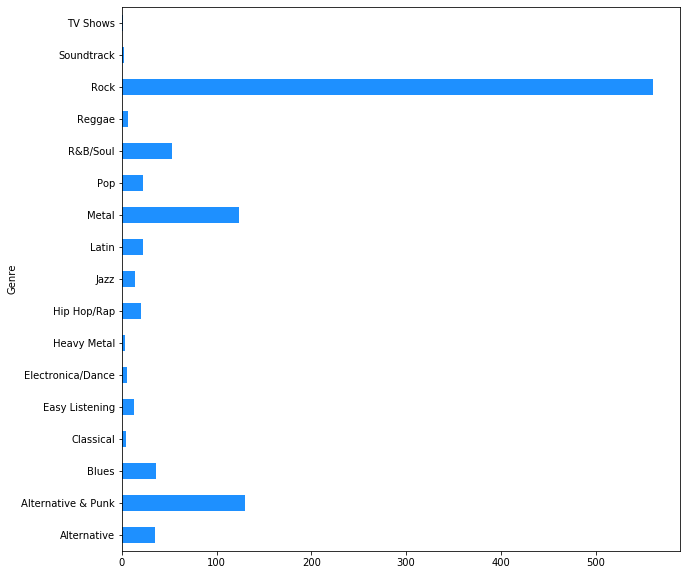

In [11]:
genre_sales_usa['Tracks_Sold'].plot.barh(figsize=(10,10), color='dodgerblue')

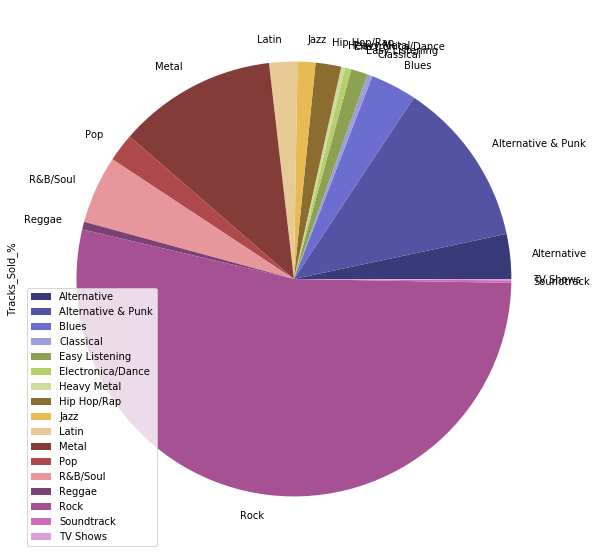

In [12]:
genre_sales_usa['Tracks_Sold_%'].plot.pie(figsize=(10,10), legend=True, colormap='tab20b')

## Observations
* The top 3 genres by far are Rock, Alternative&Punk and Metal. 
* Rock takes up more than 50% of the genre preferences so this might represent a bias on the data

In [13]:
print('-*' * 95)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


## Business Case
### You have been asked to analyze the sells of the music store to see which sales support agent is performing better or worse than others.

* Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
* Create a plot of the results of your query.

In [14]:
sales_agent_query = ''' SELECT
    A.first_name || ' ' || A.last_name employee_name,
    CAST(JULIANDAY('now') - JULIANDAY(A.hire_date) AS int) tenure_days,
    (CAST(JULIANDAY('now') - JULIANDAY(A.birthdate) AS int)) / 365 age_years,
    SUM(C.total) total_sales
    FROM employee A
    JOIN customer B
    ON A.employee_id = B.support_rep_id
    JOIN invoice C
    ON B.customer_id = C.customer_id
    GROUP BY 1
    ORDER BY 1;

'''

In [15]:
run_query(sales_agent_query)

,employee_name,tenure_days,age_years,total_sales
0,Jane Peacock,833,45,1731.51
1,Margaret Park,801,71,1584.00
2,Steve Johnson,634,54,1393.92


In [16]:
support_agent_sales = run_query(sales_agent_query)

In [17]:
support_agent_sales.set_index('employee_name', drop=True, inplace=True)

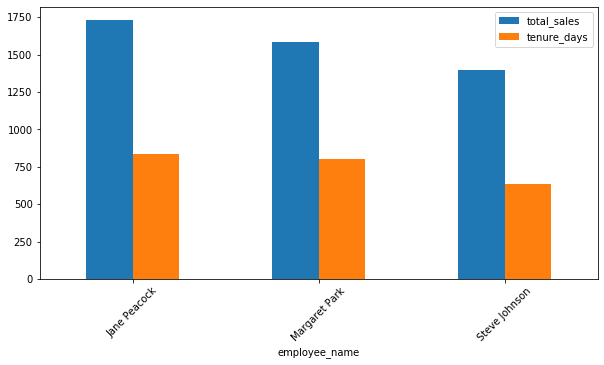

In [18]:
support_agent_sales[['total_sales','tenure_days']].plot.bar(figsize=(10,5), rot=45)

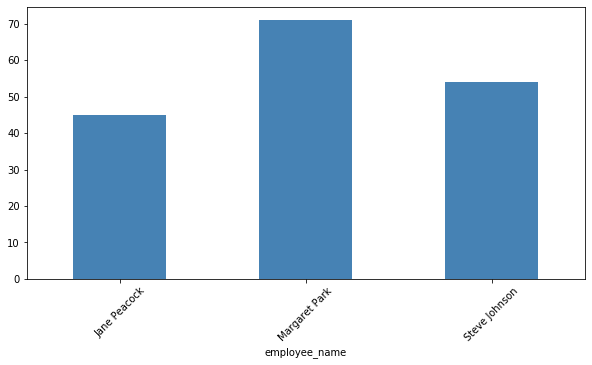

In [19]:
support_agent_sales['age_years'].plot.bar(figsize=(10,5), rot=45, color='steelblue')

## Observations
* Jane Peacock is the sales support agent with most revenue from sales, following Margaret Park and finally Steve Johnson.
* The amount of revenue correlates with the tenure days of the employee, having the employee with the most tenure also generating more revenue.
* Another observation is that the youngest employee is the one generating most revenue, the oldest employee has the second best revenue and the second youngest has the least revenue. 

In [20]:
print('-*' * 95)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


## Business Case
### You have been assigned to analyze the sales data for customers from each different country.
You have been directed to calculate data, for each country, on the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [21]:
sales_country_query = """WITH
    invoice_count AS(
        SELECT 
        customer_id,
        COUNT(invoice_id) invoiceCNT
        FROM invoice
        GROUP BY 1
    ),
    
    country_label AS(
        SELECT
        country,
        COUNT(DISTINCT customer_id) customer_count
        FROM customer
        GROUP BY 1
    ),
    
    country_stats AS (
        SELECT
        CASE
            WHEN B.customer_count == 1 THEN 'Other'
            ELSE B.country
        END AS CountryNM,
        COUNT(DISTINCT A.customer_id) CustomerCNT,
        SUM(C.total) TotalSalesAMT,
        AVG(C.total) AvgSalesCustomerAMT,
        AVG(D.invoiceCNT) AvgOrderValueNBR
        FROM customer A
        LEFT JOIN country_label B
         ON A.country = B.country
        LEFT JOIN invoice C
         ON A.customer_id = C.customer_id
        LEFT JOIN invoice_count D
         ON C.customer_id = D.customer_id
        GROUP BY 1
    )
    
    SELECT 
    CountryNM,
    CustomerCNT,
    TotalSalesAMT,
    AvgSalesCustomerAMT,
    AvgOrderValueNBR
    FROM (
        SELECT 
        T1.*,
        CASE 
            WHEN T1.CountryNM == 'Other' THEN 1
            ELSE 0
        END AS Sort
        FROM country_stats T1
    )
    ORDER BY Sort;

"""

In [22]:
run_query(sales_country_query)

,CountryNM,CustomerCNT,TotalSalesAMT,AvgSalesCustomerAMT,AvgOrderValueNBR
0,Brazil,5,427.68,7.011148,12.442623
1,Canada,8,535.59,7.047237,10.210526
2,Czech Republic,2,273.24,9.108000,15.600000
3,France,5,389.07,7.781400,10.160000
4,Germany,4,334.62,8.161463,10.317073
5,India,2,183.15,8.721429,11.095238
6,Portugal,2,185.13,6.383793,14.655172
7,USA,13,1040.49,7.942672,10.312977
8,United Kingdom,3,245.52,8.768571,9.500000
9,Other,15,1094.94,7.448571,10.183673


In [23]:
country_sales_stats = run_query(sales_country_query)

In [24]:
country_sales_stats.set_index('CountryNM', drop=True, inplace=True)

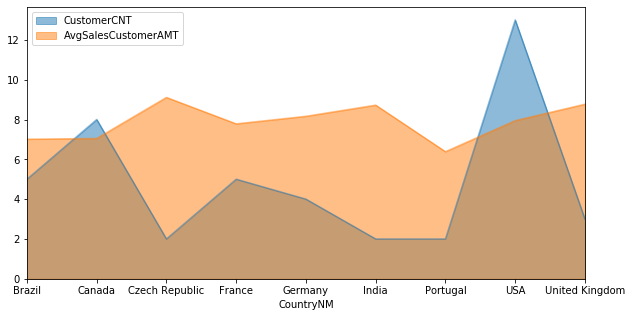

In [25]:
country_sales_stats.loc[country_sales_stats.index != 'Other',['CustomerCNT','AvgSalesCustomerAMT']].plot.area(figsize=(10,5), stacked=False)

In [26]:
country_sales_stats.head()

,CustomerCNT,TotalSalesAMT,AvgSalesCustomerAMT,AvgOrderValueNBR
CountryNM,,,,
Brazil,5,427.68,7.011148,12.442623
Canada,8,535.59,7.047237,10.210526
Czech Republic,2,273.24,9.108000,15.600000
France,5,389.07,7.781400,10.160000
Germany,4,334.62,8.161463,10.317073


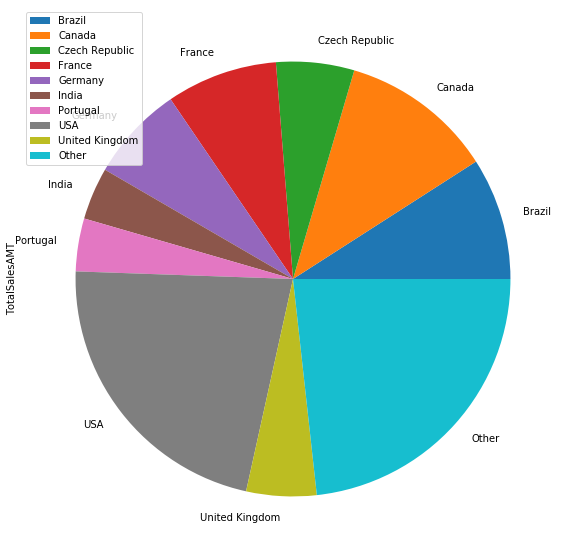

In [27]:
country_sales_stats['TotalSalesAMT'].plot.pie(figsize=(10,10), legend=True)

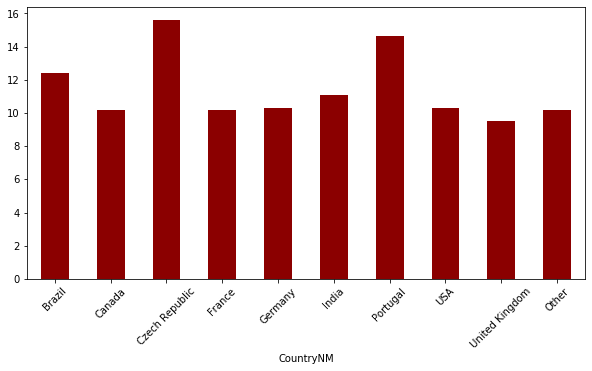

In [28]:
country_sales_stats['AvgOrderValueNBR'].plot.bar(figsize=(10,5), rot=45, color='darkred')

## Observations

* In the first plot we can find two observations to point out:
 * Czech Republic has very low customer count, nevertheless, they have the highest average sales per customer.
 * The USA has the highest customer count but a mid-to-low average sales per customer. 
* In the second chart we can see that the USA and countries categorized as 'Other' make up almost half of the total sales.
* India, despite being a huge country population wise, only accounts a small percentage in the total sales. 
* In the third chart we can find to countries that stand out among the others with the highest order value average, Czech Republic and Portugal. 
* We can also notice that the USA has below average average order values, even though they have the highest customer count, the orders are not that high.

## Recommendations
* Based on the analysis we can determine the two countries with the highest potential of growth (Czech Republic and India).
* This is because both countries have an above average order value and high average sales per customer, although, not having a big customer count. This could mean that the music service is not very popular in these countries and could mean that if more funds are invested in marketing, more customers can be acquired and, keeping the same numbers for order value and averge sales per customer, could mean that these countries will account for most of the total sales amount. 

In [29]:
print('-*' * 95)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


## Business Case
### We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

* Identify whether each invoice has all the tracks from an album.
* Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
 * Number of invoices
 * Percentage of invoices

In [30]:
print()

In [31]:
run_query("""WITH
    invoice_album AS (
        SELECT
        DISTINCT A.invoice_id,
        MIN(B.album_id) album_id
        FROM invoice_line A
        JOIN track B
        ON A.track_id = B.track_id
        GROUP BY 1
    ),

    album_purchase_query AS (
        SELECT DISTINCT
            A.invoice_id,
            A.album_id,
            CASE
                WHEN (
                        (SELECT track_id FROM invoice_line
                            WHERE invoice_id = A.invoice_id
                            EXCEPT
                            SELECT track_id FROM track
                            WHERE album_id = A.album_id) IS NULL 
                        AND
                        (SELECT track_id FROM track
                            WHERE album_id = A.album_id
                            EXCEPT
                            SELECT track_id FROM invoice_line
                            WHERE invoice_id = A.invoice_id) IS NULL
                ) THEN 1
                ELSE 0
            END AS album_purchased
            FROM invoice_album A
        )

SELECT 
    SUM(album_purchased) total_albums_purchased,
    CAST(SUM(album_purchased) AS FLOAT) / CAST(COUNT(*) AS FLOAT) album_purchasedPCT
    FROM album_purchase_query;
""")

,total_albums_purchased,album_purchasedPCT
0,114,0.185668


## Observations

* Only 18.56% of purchases represent a full album acquisition. This means that whole album purchases are not very popular and don't make up a big percentage in the total revenue.
* My recommendations would be that the music store reduce very significantly full album purchases and focus mainly on buying individual tracks from record companies. However, I wouldn't suggest to stop buying completly all albums from record companies as you might consider still buying the most popular albums as there's still a specific population that still buys these products. 

### Additional Questions for analysis:

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?